In [1]:
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.cm as cm
import yaml
import matplotlib.colors as mcolors
import pandas as pd
import subprocess
import sys
build_dir = '/Users/letshopethisworks2/CLionProjects/SALBP_ILS/cmake-build-python_interface/'

sys.path.insert(0, build_dir)
sys.path.append('../src')
sys.path.append('../src/constraint_disc')
from metrics.node_and_edge_features import randomized_kahns_algorithm
from alb_instance_compressor import *
from constraint_disc.constraint_discovery import *
from SALBP_solve import salbp1_bbr_call, parse_alb_results_new_bbr,salbp1_mhh_solve

from copy import deepcopy
import ILS_ALBP

In [2]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")

In [3]:
test_problem

{'num_tasks': 20,
 'cycle_time': 1000,
 'task_times': {'1': 599,
  '2': 464,
  '3': 579,
  '4': 489,
  '5': 624,
  '6': 430,
  '7': 411,
  '8': 524,
  '9': 478,
  '10': 585,
  '11': 570,
  '12': 622,
  '13': 452,
  '14': 344,
  '15': 720,
  '16': 502,
  '17': 355,
  '18': 813,
  '19': 342,
  '20': 473},
 'precedence_relations': [['1', '5'],
  ['2', '7'],
  ['3', '8'],
  ['4', '6'],
  ['4', '9'],
  ['4', '10'],
  ['5', '11'],
  ['6', '12'],
  ['7', '13'],
  ['8', '13'],
  ['11', '15'],
  ['12', '14'],
  ['13', '16'],
  ['13', '17'],
  ['14', '18'],
  ['15', '19'],
  ['16', '20']]}

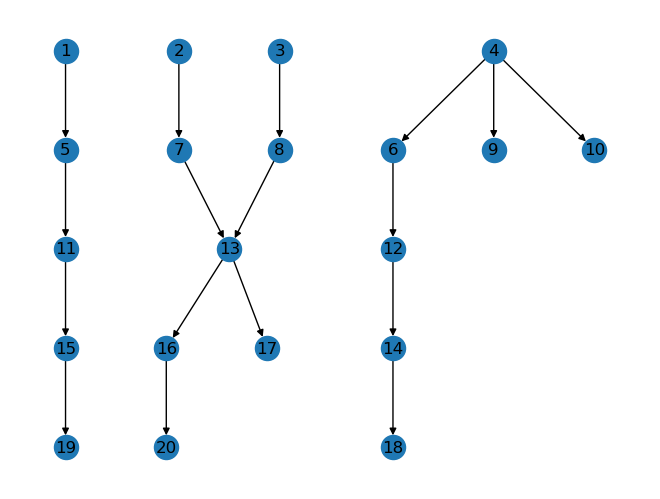

In [4]:
def plot_salbp_graph(G):
    # Compute layout
    pos = nx.nx_agraph.graphviz_layout(G, prog='dot')

    # Extract edge probabilities (default to 0 if missing)
    edge_probs = [G[u][v].get('prob', 0) for u, v in G.edges()]
    
    # Normalize for color mapping
    vmin, vmax = min(edge_probs), max(edge_probs)

    # Create figure and axis explicitly
    fig, ax = plt.subplots(figsize=(8, 6))

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=800, edgecolors='black', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=10, font_color='black', ax=ax)

    # Draw edges with colormap
    edges = nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_probs,
        edge_cmap=plt.cm.viridis,
        edge_vmin=vmin,
        edge_vmax=vmax,
        width=2,
        ax=ax
    )

    # Add colorbar *using the same Axes*
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])  # required for colorbar
    fig.colorbar(sm, ax=ax, label="Edge Probability")

    # Final touches
    ax.set_title("SALBP Graph Colored by Edge Probability")
    ax.axis("off")
    plt.tight_layout()
    plt.show()
plot_salbp_dict(test_problem)

In [5]:
feasible_sequences = get_feasible_seq(test_problem, 2, 42)
print(feasible_sequences)

G_max_close = seqs_to_dag(feasible_sequences)






[['1', '2', '5', '4', '6', '7', '3', '12', '8', '14', '13', '9', '10', '11', '16', '17', '20', '15', '18', '19'], ['2', '7', '4', '6', '1', '5', '11', '10', '12', '9', '3', '14', '8', '13', '18', '15', '17', '19', '16', '20']]


In [6]:

edge_probs = edge_prob_generation(test_problem, G_max_close, seed=42)
nx.set_edge_attributes(G_max_close, edge_probs, name='prob')
G_max_red = nx.transitive_reduction(G_max_close)
nx.set_edge_attributes(G_max_red, edge_probs, name='prob')
edge_probs

Seed is  42
edges to perturb,  [('12', '14'), ('1', '16'), ('2', '7'), ('2', '17'), ('2', '12'), ('12', '8'), ('11', '20'), ('8', '13'), ('11', '16'), ('5', '3'), ('1', '18'), ('1', '17'), ('11', '17'), ('2', '10'), ('2', '14'), ('7', '14'), ('9', '19'), ('15', '19'), ('5', '20'), ('2', '11'), ('6', '13'), ('2', '8'), ('1', '11'), ('13', '18'), ('8', '17'), ('14', '13'), ('9', '15'), ('10', '19'), ('12', '13'), ('6', '3')]


{('16', '20'): 0.1,
 ('8', '13'): 0.9,
 ('15', '19'): 0.9,
 ('7', '13'): 0.1,
 ('2', '7'): 0.9,
 ('4', '9'): 0.1,
 ('6', '12'): 0.1,
 ('12', '14'): 0.9,
 ('3', '8'): 0.1,
 ('13', '17'): 0.1,
 ('11', '15'): 0.1,
 ('1', '5'): 0.1,
 ('4', '10'): 0.1,
 ('13', '16'): 0.1,
 ('14', '18'): 0.1,
 ('4', '6'): 0.1,
 ('5', '11'): 0.1,
 ('8', '17'): 0.1,
 ('10', '20'): 0.9,
 ('6', '10'): 0.9,
 ('1', '20'): 0.9,
 ('7', '18'): 0.9,
 ('2', '11'): 0.1,
 ('3', '17'): 0.9,
 ('9', '17'): 0.9,
 ('7', '12'): 0.9,
 ('8', '16'): 0.9,
 ('14', '13'): 0.1,
 ('6', '18'): 0.9,
 ('8', '19'): 0.9,
 ('1', '13'): 0.9,
 ('5', '20'): 0.1,
 ('7', '11'): 0.9,
 ('3', '16'): 0.9,
 ('5', '17'): 0.9,
 ('9', '16'): 0.9,
 ('4', '14'): 0.9,
 ('8', '15'): 0.9,
 ('5', '3'): 0.1,
 ('3', '19'): 0.9,
 ('9', '19'): 0.1,
 ('18', '19'): 0.9,
 ('11', '17'): 0.1,
 ('4', '18'): 0.9,
 ('3', '15'): 0.9,
 ('6', '11'): 0.9,
 ('9', '15'): 0.1,
 ('5', '16'): 0.9,
 ('1', '8'): 0.9,
 ('12', '20'): 0.9,
 ('4', '12'): 0.9,
 ('2', '20'): 0.9,
 ('13',

In [7]:
set1 = set([('2', '5'), ('4', '6'), ('2', '19'), ('2', '10'), ('12', '15'), ('1', '12'), ('4', '18'), ('7', '9'), ('10', '18'), ('5', '20'), ('6', '12'), ('1', '5'), ('5', '3'), ('8', '17'), ('10', '15'), ('5', '14'), ('7', '18'), ('6', '19'), ('12', '9'), ('7', '14'), ('6', '9'), ('8', '15'), ('8', '13'), ('1', '17'), ('9', '18'), ('12', '20'), ('2', '18'), ('11', '20'), ('7', '12'), ('5', '15')])
set2 = set([('5', '13'), ('4', '9'), ('7', '15'), ('6', '14'), ('2', '15'), ('2', '13'), ('7', '16'), ('8', '17'), ('3', '19'), ('2', '6'), ('13', '16'), ('16', '20'), ('4', '11'), ('2', '14'), ('13', '20'), ('4', '20'), ('6', '16'), ('8', '18'), ('7', '17'), ('14', '19'), ('14', '13'), ('4', '12'), ('5', '11'), ('5', '15'), ('10', '17'), ('6', '13'), ('11', '16'), ('9', '20'), ('7', '9'), ('7', '20')])
set2

{('10', '17'),
 ('11', '16'),
 ('13', '16'),
 ('13', '20'),
 ('14', '13'),
 ('14', '19'),
 ('16', '20'),
 ('2', '13'),
 ('2', '14'),
 ('2', '15'),
 ('2', '6'),
 ('3', '19'),
 ('4', '11'),
 ('4', '12'),
 ('4', '20'),
 ('4', '9'),
 ('5', '11'),
 ('5', '13'),
 ('5', '15'),
 ('6', '13'),
 ('6', '14'),
 ('6', '16'),
 ('7', '15'),
 ('7', '16'),
 ('7', '17'),
 ('7', '20'),
 ('7', '9'),
 ('8', '17'),
 ('8', '18'),
 ('9', '20')}

[('5', '13'), ('4', '9'), ('7', '15'), ('6', '14'), ('2', '15'), ('2', '13'), ('7', '16'), ('8', '17'), ('3', '19'), ('2', '6'), ('13', '16'), ('16', '20'), ('4', '11'), ('2', '14'), ('13', '20'), ('4', '20'), ('6', '16'), ('8', '18'), ('7', '17'), ('14', '19'), ('14', '13'), ('4', '12'), ('5', '11'), ('5', '15'), ('10', '17'), ('6', '13'), ('11', '16'), ('9', '20'), ('7', '9'), ('7', '20')]

In [8]:
G_max_red.edges(data=True)

OutEdgeDataView([('1', '5', {'prob': 0.1}), ('2', '7', {'prob': 0.9}), ('2', '4', {'prob': 0.9}), ('2', '5', {'prob': 0.9}), ('5', '11', {'prob': 0.1}), ('5', '12', {'prob': 0.9}), ('5', '3', {'prob': 0.1}), ('5', '10', {'prob': 0.9}), ('4', '6', {'prob': 0.1}), ('6', '11', {'prob': 0.9}), ('6', '12', {'prob': 0.1}), ('6', '3', {'prob': 0.1}), ('6', '10', {'prob': 0.9}), ('7', '11', {'prob': 0.9}), ('7', '12', {'prob': 0.9}), ('7', '3', {'prob': 0.9}), ('7', '10', {'prob': 0.9}), ('3', '14', {'prob': 0.9}), ('3', '8', {'prob': 0.1}), ('12', '9', {'prob': 0.9}), ('12', '14', {'prob': 0.9}), ('12', '8', {'prob': 0.1}), ('8', '13', {'prob': 0.9}), ('14', '13', {'prob': 0.1}), ('13', '18', {'prob': 0.1}), ('13', '16', {'prob': 0.1}), ('13', '17', {'prob': 0.1}), ('13', '15', {'prob': 0.9}), ('9', '18', {'prob': 0.9}), ('9', '16', {'prob': 0.9}), ('9', '17', {'prob': 0.9}), ('9', '15', {'prob': 0.1}), ('10', '18', {'prob': 0.9}), ('10', '16', {'prob': 0.9}), ('10', '17', {'prob': 0.9}), ('1

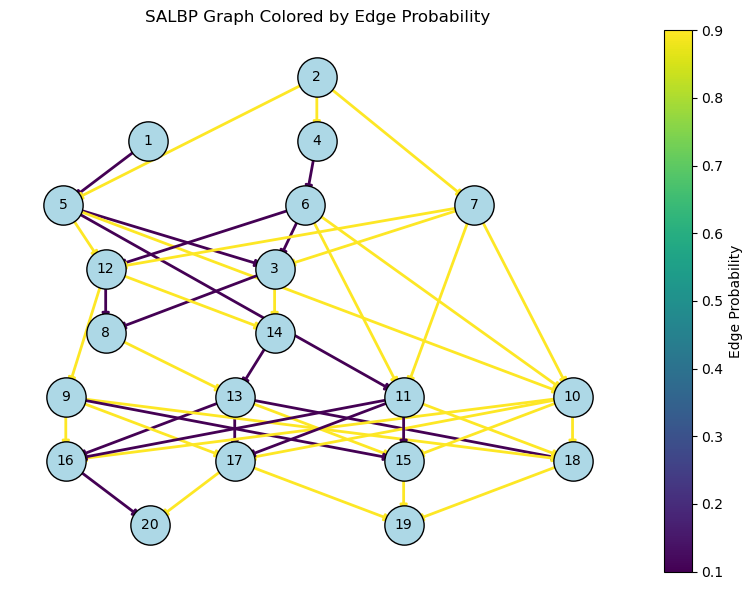

In [9]:
plot_salbp_graph(G_max_red)

In [10]:
test_problem

{'num_tasks': 20,
 'cycle_time': 1000,
 'task_times': {'1': 599,
  '2': 464,
  '3': 579,
  '4': 489,
  '5': 624,
  '6': 430,
  '7': 411,
  '8': 524,
  '9': 478,
  '10': 585,
  '11': 570,
  '12': 622,
  '13': 452,
  '14': 344,
  '15': 720,
  '16': 502,
  '17': 355,
  '18': 813,
  '19': 342,
  '20': 473},
 'precedence_relations': [['1', '5'],
  ['2', '7'],
  ['3', '8'],
  ['4', '6'],
  ['4', '9'],
  ['4', '10'],
  ['5', '11'],
  ['6', '12'],
  ['7', '13'],
  ['8', '13'],
  ['11', '15'],
  ['12', '14'],
  ['13', '16'],
  ['13', '17'],
  ['14', '18'],
  ['15', '19'],
  ['16', '20']]}

In [11]:
G_max_close.edges(data=True)

OutEdgeDataView([('1', '3', {'prob': 0.9}), ('1', '5', {'prob': 0.1}), ('1', '8', {'prob': 0.9}), ('1', '9', {'prob': 0.9}), ('1', '10', {'prob': 0.9}), ('1', '11', {'prob': 0.1}), ('1', '12', {'prob': 0.9}), ('1', '13', {'prob': 0.9}), ('1', '14', {'prob': 0.9}), ('1', '15', {'prob': 0.9}), ('1', '16', {'prob': 0.1}), ('1', '17', {'prob': 0.1}), ('1', '18', {'prob': 0.1}), ('1', '19', {'prob': 0.9}), ('1', '20', {'prob': 0.9}), ('2', '3', {'prob': 0.9}), ('2', '4', {'prob': 0.9}), ('2', '5', {'prob': 0.9}), ('2', '6', {'prob': 0.9}), ('2', '7', {'prob': 0.9}), ('2', '8', {'prob': 0.1}), ('2', '9', {'prob': 0.9}), ('2', '10', {'prob': 0.1}), ('2', '11', {'prob': 0.1}), ('2', '12', {'prob': 0.1}), ('2', '13', {'prob': 0.9}), ('2', '14', {'prob': 0.1}), ('2', '15', {'prob': 0.9}), ('2', '16', {'prob': 0.9}), ('2', '17', {'prob': 0.1}), ('2', '18', {'prob': 0.9}), ('2', '19', {'prob': 0.9}), ('2', '20', {'prob': 0.9}), ('5', '3', {'prob': 0.1}), ('5', '8', {'prob': 0.9}), ('5', '9', {'pro

In [12]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_hoff_solve
mh=constant_weight
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
beam_config= {'width':3, 'depth':3}
#beam_config= {'width':1, 'depth':1}
do_greedy_run(test_problem, 5, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config,)

Elites are: [Solution(accumulated_reward=11.700000000000001, state_probability=0.9, value=1, edges=[('2', '4')]), Solution(accumulated_reward=11.700000000000001, state_probability=0.9, value=1, edges=[('2', '7')]), Solution(accumulated_reward=11.700000000000001, state_probability=0.9, value=1, edges=[('2', '5')])]
Elites are: [Solution(accumulated_reward=11.700000000000001, state_probability=0.81, value=1, edges=[('2', '4'), ('2', '7')]), Solution(accumulated_reward=11.700000000000001, state_probability=0.09000000000000001, value=1, edges=[('2', '4'), ('1', '5')]), Solution(accumulated_reward=11.700000000000001, state_probability=0.81, value=1, edges=[('2', '4'), ('2', '5')])]
Elites are: [Solution(accumulated_reward=11.700000000000001, state_probability=0.81, value=1, edges=[('2', '4'), ('2', '5')]), Solution(accumulated_reward=11.700000000000001, state_probability=0.09000000000000001, value=1, edges=[('2', '4'), ('1', '5')]), Solution(accumulated_reward=11.700000000000001, state_prob

{'time': 2.361959934234619,
 'OS': [0.8,
  0.8,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526],
 'query_values': [14, 14, 14, 14, 14, 14],
 'q_time': [0.3550589084625244,
  0.43645310401916504,
  0.3760700225830078,
  0.39433908462524414,
  0.4068169593811035,
  0.39301204681396484],
 'bin_lb': 12,
 'edges': [(), ('2', '7'), ('2', '4'), ('2', '5'), ('2', '6'), ('5', '12')]}

In [13]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
mh = constant_weight
#mh = salbp1_hoff_solve
selector_method = "random"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 15, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

{'time': 4.312458038330078,
 'OS': [0.8,
  0.8,
  0.7947368421052632,
  0.7894736842105263,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7631578947368421,
  0.7578947368421053,
  0.7526315789473684,
  0.7526315789473684,
  0.7473684210526316,
  0.7473684210526316],
 'query_values': [14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14],
 'q_time': [0.26855921745300293,
  0.26511406898498535,
  0.2835400104522705,
  0.3362710475921631,
  0.2597482204437256,
  0.2768089771270752,
  0.2706937789916992,
  0.2673368453979492,
  0.24785900115966797,
  0.26807212829589844,
  0.25468897819519043,
  0.25942492485046387,
  0.27696990966796875,
  0.2654242515563965,
  0.2687947750091553,
  0.24280405044555664],
 'bin_lb': 12,
 'edges': [(),
  ('16', '20'),
  ('5', '10'),
  ('1', '10', 0.9),
  ('3', '8', 0.1),
  ('7', '10', 0.9),
  ('7', '3', 0.9),
  ('6', '11', 0.9),


In [14]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
mh = constant_weight
#mh = salbp1_hoff_solve
selector_method = "beam_prob"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
#beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 15, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

Elites are: [Solution(accumulated_reward=0.9, state_probability=0.9, value=0, edges=[('2', '4')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=0, edges=[('2', '7')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=0, edges=[('2', '5')])]
Elites are: [Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('2', '5')]), Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('2', '7')]), Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('5', '12')])]
Elites are: [Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('5', '12')]), Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('2', '7')]), Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '7'), ('2', '5')])]
Elites are: [Solution(accumulated_reward=1.71, state_probability=0.81, value=0, edges=[('2', '4'), ('

{'time': 5.350752115249634,
 'OS': [0.8,
  0.8,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789,
  0.7631578947368421,
  0.7578947368421053,
  0.7526315789473684,
  0.7473684210526316,
  0.7421052631578947,
  0.7368421052631579,
  0.7315789473684211,
  0.7263157894736842],
 'query_values': [14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  14,
  13,
  13,
  13,
  13,
  13,
  13,
  13],
 'q_time': [0.2612287998199463,
  0.3497021198272705,
  0.34252309799194336,
  0.33969616889953613,
  0.3550751209259033,
  0.35193681716918945,
  0.33663296699523926,
  0.3329582214355469,
  0.3295450210571289,
  0.3257741928100586,
  0.33335185050964355,
  0.3381500244140625,
  0.3319261074066162,
  0.3473658561706543,
  0.34576892852783203,
  0.32891106605529785],
 'bin_lb': 12,
 'edges': [(),
  ('2', '7'),
  ('2', '4'),
  ('2', '5'),
  ('2', '6'),
  ('5', '10'),
  ('1', '10'),
  ('6', '11'),
  ('4', '11'),
  ('6', '10'),

In [15]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
mh = salbp1_prioirity_solve
#mh = salbp1_hoff_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 20, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)

Elites are: [Solution(accumulated_reward=0, state_probability=0.9, value=14, edges=[('2', '7')]), Solution(accumulated_reward=0, state_probability=0.9, value=14, edges=[('6', '11')]), Solution(accumulated_reward=0.1, state_probability=0.1, value=13, edges=[('6', '3')]), Solution(accumulated_reward=0, state_probability=0.9, value=14, edges=[('2', '5')]), Solution(accumulated_reward=0.1, state_probability=0.1, value=13, edges=[('11', '16')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=13, edges=[('9', '17')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=13, edges=[('10', '16')]), Solution(accumulated_reward=0, state_probability=0.9, value=14, edges=[('5', '10')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=13, edges=[('6', '10')]), Solution(accumulated_reward=0.9, state_probability=0.9, value=13, edges=[('7', '11')])]
Elites are: [Solution(accumulated_reward=0.9, state_probability=0.81, value=13, edges=[('9', '17'), ('2', '4')]), So

{'time': 7.491352081298828,
 'OS': [0.8, 0.7947368421052632, 0.7894736842105263],
 'query_values': [14, 13, 12],
 'q_time': [0.26499009132385254, 3.7036678791046143, 3.5224030017852783],
 'bin_lb': 12,
 'edges': [(), ('9', '17'), ('7', '11')]}

In [16]:
test_problem = parse_alb("/Users/letshopethisworks2/Documents/phd_paper_material/DADA/small data set_n=20/instance_n=20_16.alb")
#mh = os_weight
#mh = salbp1_prioirity_solve
mh = salbp1_mhh_solve
selector_method = "beam_mh"
ex_fp = "/Users/letshopethisworks2/Documents/phd_paper_material/BBR-for-SALBP1/SALB/SALB/salb"
#beam_config= {'width':3, 'depth':3}
beam_config= {'width':10, 'depth':3}
do_greedy_run(test_problem, 10, G_max_close, ex_fp, mh,selector_method, time_limit=1,seed=42,beam_config= beam_config)


 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve complete. UB=14 LB=11
Starting reverse solve...
Reverse order setup complete
Reverse solve complete

 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve complete. UB=14 LB=11
Starting reverse solve...
Reverse order setup complete
Reverse solve complete

 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve complete. UB=14 LB=11
Starting reverse solve...
Reverse order setup complete
Reverse solve complete

 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve complete. UB=14 LB=11
Starting reverse solve...
Reverse order setup complete
Reverse solve complete

 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve complete. UB=14 LB=11
Starting reverse solve...
Reverse order setup complete
Reverse solve complete

 Starting forward solve...
saving best solution, n stations 14
 
 
 Forward solve co

{'time': 10.959157943725586,
 'OS': [0.8,
  0.7947368421052632,
  0.7947368421052632,
  0.7894736842105263,
  0.7842105263157895,
  0.7789473684210526,
  0.7736842105263158,
  0.7684210526315789],
 'query_values': [14, 13, 13, 13, 13, 13, 13, 12],
 'q_time': [0.2616288661956787,
  1.5461876392364502,
  1.516374111175537,
  1.5433616638183594,
  1.5868680477142334,
  1.5320088863372803,
  1.4897840023040771,
  1.4822509288787842],
 'bin_lb': 12,
 'edges': [(),
  ('9', '17'),
  ('2', '7'),
  ('5', '12'),
  ('1', '12'),
  ('5', '9'),
  ('1', '9'),
  ('7', '11')]}

In [17]:
import networkx as nx


In [18]:
#test_to_remove = [('10', '16'), ('17', '19'), ('2', '5'), ('7', '11')]
test_to_remove = [('6','3')
]
# test_to_remove = [('2', '4'),
#   ('2', '6'),
#   ('5', '3'),
#   ('5', '12'),
#   ('5', '8'),
#   ('5', '10'),
#   ('1', '10'),
#   ('5', '9'),
#   ('1', '12'),
#   ('1', '9'),
#   ('5', '14'),
#   ('5', '13'),
#   ('7', '3'),
#   ('2', '3'),
#   ('7', '12'),
#   ('7', '9'),
#   ('7', '14'),
#   ('3', '8'),
#   ('3', '14'),
# ]
test_gmax_close = G_max_close.copy()
print("before", test_gmax_close)
test_gmax_close.remove_edges_from(test_to_remove)
print("after", test_gmax_close)

G_max_red = nx.transitive_reduction(test_gmax_close)
test_salbp, new_to_old = set_new_edges(G_max_red, test_problem)
orig_bbr = False
if "BBR-for-SALBP1/" in ex_fp:
    orig_bbr = True
res = salbp1_bbr_call(test_salbp,ex_fp, 1, w_bin_pack=True, time_limit=2, orig_bbr=orig_bbr)
print('n_stations', res['n_stations'])
task_station = {}
for i, station in enumerate(res['task_assignments']):
    task_station[new_to_old[str(i+1)]] = station
sorted_dict = dict(sorted(task_station.items(), key=(lambda x: int(x[0]))))
true_assignments = [val for _,  val in sorted_dict.items()]
true_assignments
def check_feasibility_C(orig_problem, assignments, cycle_time=1000):
    station_loads = [0] * max(assignments)
    for task, station in enumerate(assignments):
        
        station_loads[station-1] += orig_problem['task_times'][str(task+1)]
    print("here are the station loads: ", station_loads)
    if max(station_loads)>cycle_time:
        idx, max_val = max(enumerate(station_loads), key=lambda x: x[1])
        print("Issue! ", idx, max_val)
check_feasibility_C(test_problem, true_assignments)


before DiGraph with 20 nodes and 152 edges
after DiGraph with 20 nodes and 151 edges
n_stations 13
here are the station loads:  [599, 953, 624, 990, 1000, 585, 622, 822, 976, 720, 813, 697, 975]


In [19]:

def lstd_search( orig_salbp, G_max_close_orig,G_min, mh, beam_config = {"width":1, "depth":1} , init_sol = None, **mhkwargs):
    width = beam_config["width"]
    depth = beam_config["depth"]
    G_max_close= G_max_close_orig.copy()
    G_max_red = nx.transitive_reduction(G_max_close)
    G_max_red.add_edges_from((u, v, G_max_close.edges[u, v]) for u, v in G_max_red.edges)
    #Initial solution
    if not init_sol:
        res = mh(new_salbp, **mhkwargs)
    else:
        res = init_sol
    init_sol = Solution(0,1,res['n_stations'], [])
    history = set()
    queue = [init_sol]  # Queue of Solution(obj_val, removed_edges) 
    for c_d in range(depth):
        elites = EliteSet(width)

        while len(queue) > 0:
            old_sol= queue.pop(0)
            removed_edges = old_sol.edges
            edges = get_possible_edges(G_max_red, G_min, removed_edges)
            for i, edge in enumerate(edges):
                        #This is to avoid repeat computations (i.e. e1->e2, e2->e1)
                
                new_removed = removed_edges+ [(edge[0], edge[1])]
                edge_set = frozenset(new_removed)
                
                if edge_set in history:
                    continue
                # Store the current removal sequence
                history.add(edge_set)
                # Create list without current item
                G_max_red = remove_edges(G_max_close, new_removed)
                new_salbp, new_to_old = set_new_edges(G_max_red, orig_salbp)
                res = mh(new_salbp, **mhkwargs)
                if len(edge) ==3:
                    edge_prob = edge[2]
                else:
                    edge_prob = 1
                prob = old_sol.state_probability * edge_prob #Overall likelihood is the probability of reaching previous states times the probability of the current
                reward = old_sol.accumulated_reward+ max( 0, prob*(old_sol.value - res['n_stations']))
                #print(f"acc reward: {old_sol.accumulated_reward}, probability: {probability}, old_sol.value {old_sol.value}, current val {res["n_stations"]}")
                #For noisy heuristics, new value could be higher than old value, even if problem is a relaxation
                best_value = min(res['n_stations'], old_sol.value) 
                sol = Solution(reward,prob,best_value, new_removed)
                elites.add(sol)
        if c_d > 1:
            if elites.same_first_edge():
                
                # print("elites agree on next move. proceeding to query")
                # print(elites.get_elites())
                break
        queue = elites.get_elites(sort_elites=True)
    sol = elites.best()
    obj = sol.accumulated_reward
    edges = sol.edges
    return edges[0], obj